In [6]:
package CauseAndEffectExample {
	import CauseAndEffect::*;
	
	part def Causer1;
	part def Causer2;
	part def Effected1;
	part def Effected2;
	
	#multicausation connection def MultiCauseEffect {
		end #cause cause1 : Causer1;
		end #cause cause2 : Causer2;
		end #effect effect1 : Effected1;
		end #effect effect2 : Effected2;
	}
	
	part causer1 : Causer1;
	part causer2 : Causer2;
	part effected1 : Effected1;
	part effected2 : Effected2;
	
	#multicausation connection : MultiCauseEffect connect
		( cause1 ::> causer1, cause2 ::> causer2,
		  effect1 ::> effected1, effect2 ::> effected2 );
		  
	#multicausation connect
		( cause1 ::> causer1, cause2 ::> causer2,
		  effect1 ::> effected1, effect2 ::> effected2 );

    occurrence a;
    item b;
    part c;
    action d;
    
	#multicausation connection {
		end #cause ::> a;
		end #cause ::> b;
		end #effect ::> c;
		end #effect ::> d;
	}
	
	#cause causeA ::> a;
	#cause causeB ::> b;
	#effect effectC ::> c;
	#effect effectD ::> d;
	
	#multicausation connect ( causeA, causeB, effectC, effectD );
	
	#causation connect a to c;
	#causation connect b to d {
		@CausationMetadata {
			isNecessary = true;
			probability = 0.1;
		}
	}
}


Package CauseAndEffectExample (b294b63e-6dd4-4e58-a862-29f4f1772739)


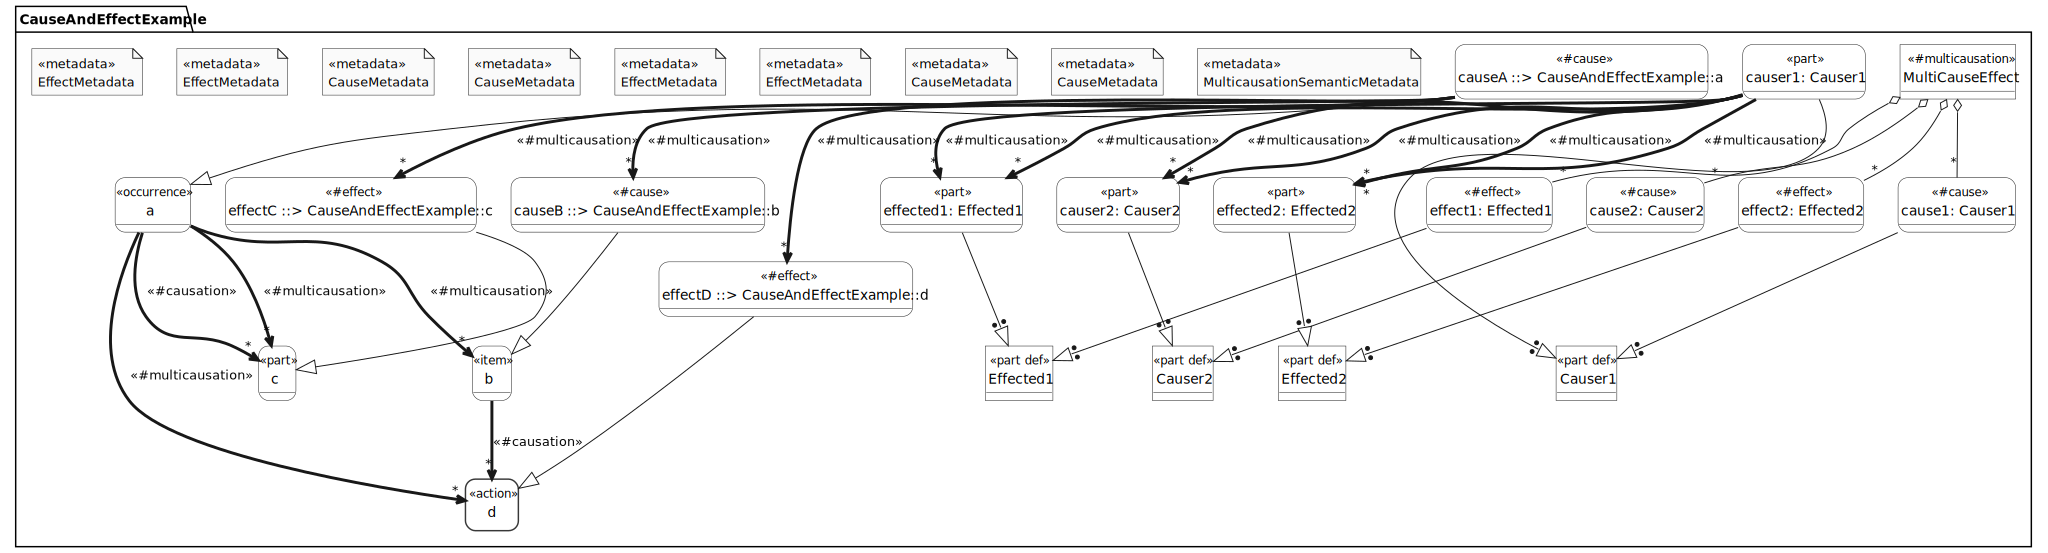

In [7]:
%viz CauseAndEffectExample

In [8]:
package PictureTaking {
	part def Exposure;
	
	action def Focus { out xrsl: Exposure; }
	action def Shoot { in xsf: Exposure; }	
		
	action takePicture {		
		action focus: Focus[1];
		flow focus.xrsl to shoot.xsf;
		action shoot: Shoot[1];
	}
}

Package PictureTaking (01c760e9-824e-4c57-9a8d-7110490595d0)


In [9]:
part def Camera {
	import PictureTaking::*;
	
	perform action takePicture[*] :> PictureTaking::takePicture;
	
	part focusingSubsystem {
		perform takePicture.focus;
	}
	
	part imagingSubsystem {
		perform takePicture.shoot;
	}
	
}

PartDefinition Camera (38ef4626-1b87-464c-b340-1ea65dd0fcde)


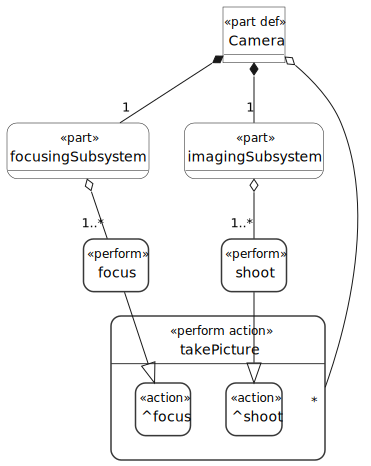

In [10]:
%viz --view=default Camera

In [11]:
package VehicleGeometryAndCoordinateFrames {
    import TrigFunctions::*;
    import ISQ::*;
	import SI::*;
	import Time::*;

    import ShapeItems::*;
    import SpatialItems::*;

    import MeasurementReferences::CoordinateFrame;
    import MeasurementReferences::TranslationRotationSequence;
    import MeasurementReferences::Translation;
    import MeasurementReferences::Rotation;
    
    private import Collections::Array;
    private import ScalarValues::Boolean;
    private import ScalarValues::Real;
    private import ScalarValues::Natural;
	private import ControlFunctions::forAll;
    
    part def Vehicle :> SpatialItem;

    part def Chassis :> SpatialItem {
        item :>> shape = Box(4800 [mm], 1840 [mm], 1350 [mm]);
    }

    part def Wheel :> SpatialItem {
		doc
		/*
		 * Generic wheel with lugbolts
		 * 
		 * The radius is estimated for a 22 inch hub plus 110 mm tire height.
		 * The wheel width is equal to the cylinder height.
		 * The wheel has 5 lugbolts that are evenly distributed along a circle centered at the wheel's center.
		 */
	
    	ref item :>> self : Wheel;
        item :>> shape : Cylinder {
            :>> radius = 22/2*25.4 + 110 [mm]; 
            :>> height = 220 [mm];
        }
        attribute <wcf> wheelCoordinateFrame : CoordinateFrame;
        
        attribute numberOfBolts : Natural = 5;	
		part lugBolts : LugBolt[1..numberOfBolts];
		
		/* 
		 * As an example of a more involved placement of composite parts, constrain the positions of the coordinate frame origins 
		 * of the lugbolts to a circle with radius lbpr distributed evenly over 360°.
		 */
        attribute <lbpr> lugBoltPlacementRadius :>> radius default 60 [mm];
		private attribute lugBoltDistributionAngle :>> planeAngle = 360/numberOfBolts ['°'];
        private attribute lbda : Real = lugBoltDistributionAngle.num * (pi/180); // lugBoltDistributionAngle in radian
		assert constraint {
			(1..numberOfBolts)->forAll {
				in i : Natural;
				private attribute lbcf = lugBolts#(i).coordinateFrame; 
				private attribute trs : TranslationRotationSequence {
					:>> source = wcf;
					:>> target = lbcf;
					:>> elements = Translation((lbpr*cos((i-1)*lbda), lbpr*sin((i-1)*lbda), -8)[wcf]); 
				}
				lbcf.transformation == trs
			}
		}
    }

    part def LugBolt :> SpatialItem {
    	item :>> shape : Cylinder {
    		:>> radius = 14 [mm];
    		:>> height = 40 [mm];
    	}
    }

    part vehicle : Vehicle, SpatialItem {
		/* 
		 * Vehicle frame origin at center of bottom plate of chassis
		 * with +Z upwards and +X in the forward (front) direction
		 */
        attribute datum :>> coordinateFrame {
            :>> mRefs = (mm, mm, mm);
        }

        part chassis : Chassis[1] :> componentItems {
			attribute :>> coordinateFrame {
				attribute :>> transformation : TranslationRotationSequence {
	 	          	attribute :>> source = datum;
                	attribute :>> elements = Translation((-(shape as Box).length/2, -(shape as Box).width/2, 0)[datum]);
                }
			}
        }

        private attribute plusXAxis : Array { :>> dimensions = 3; :>> elements : Real[3] = (1, 0, 0); }
        private attribute frontWheelXShift : Real = 1670;
        private attribute rearWheelXShift : Real = -1820;
        private attribute wheelYShift : Real = 720;

        part leftFrontWheel : Wheel[1] :> componentItems {
            attribute :>> coordinateFrame {
                attribute :>> transformation : TranslationRotationSequence {
	            	attribute :>> source = datum;
                	attribute :>> elements = (Translation((frontWheelXShift, wheelYShift, 80)[datum]), Rotation(plusXAxis[datum], -90['°']));
                }
            }
        }
        part rightFrontWheel : Wheel[1] :> componentItems {
            attribute :>> coordinateFrame {
                attribute :>> transformation : TranslationRotationSequence {
                	attribute :>> source = datum;
                	attribute :>> elements = (Translation((frontWheelXShift, -wheelYShift, 80)[datum]), Rotation((1, 0, 0)[datum], 90['°']));
                }
            }
        }
        part leftRearWheel : Wheel[1] :> componentItems {
            attribute :>> coordinateFrame {
                attribute :>> transformation : TranslationRotationSequence {
                	attribute :>> source = datum;
                	attribute :>> elements = (Translation((rearWheelXShift, wheelYShift, 80)[datum]), Rotation((1, 0, 0)[datum], 90['°']));
                }
            }
        }
        part rightRearWheel : Wheel[1] :> componentItems {
            attribute :>> coordinateFrame {
                attribute :>> transformation : TranslationRotationSequence {
					attribute :>> source = datum;
                	attribute :>> elements = (Translation((rearWheelXShift, -wheelYShift, 80)[datum]), Rotation((-1, 0, 0)[datum], 90['°']));
                }
            }
        }
    }
}


Package VehicleGeometryAndCoordinateFrames (c401f9d7-00f0-48d7-a115-999a49700926)


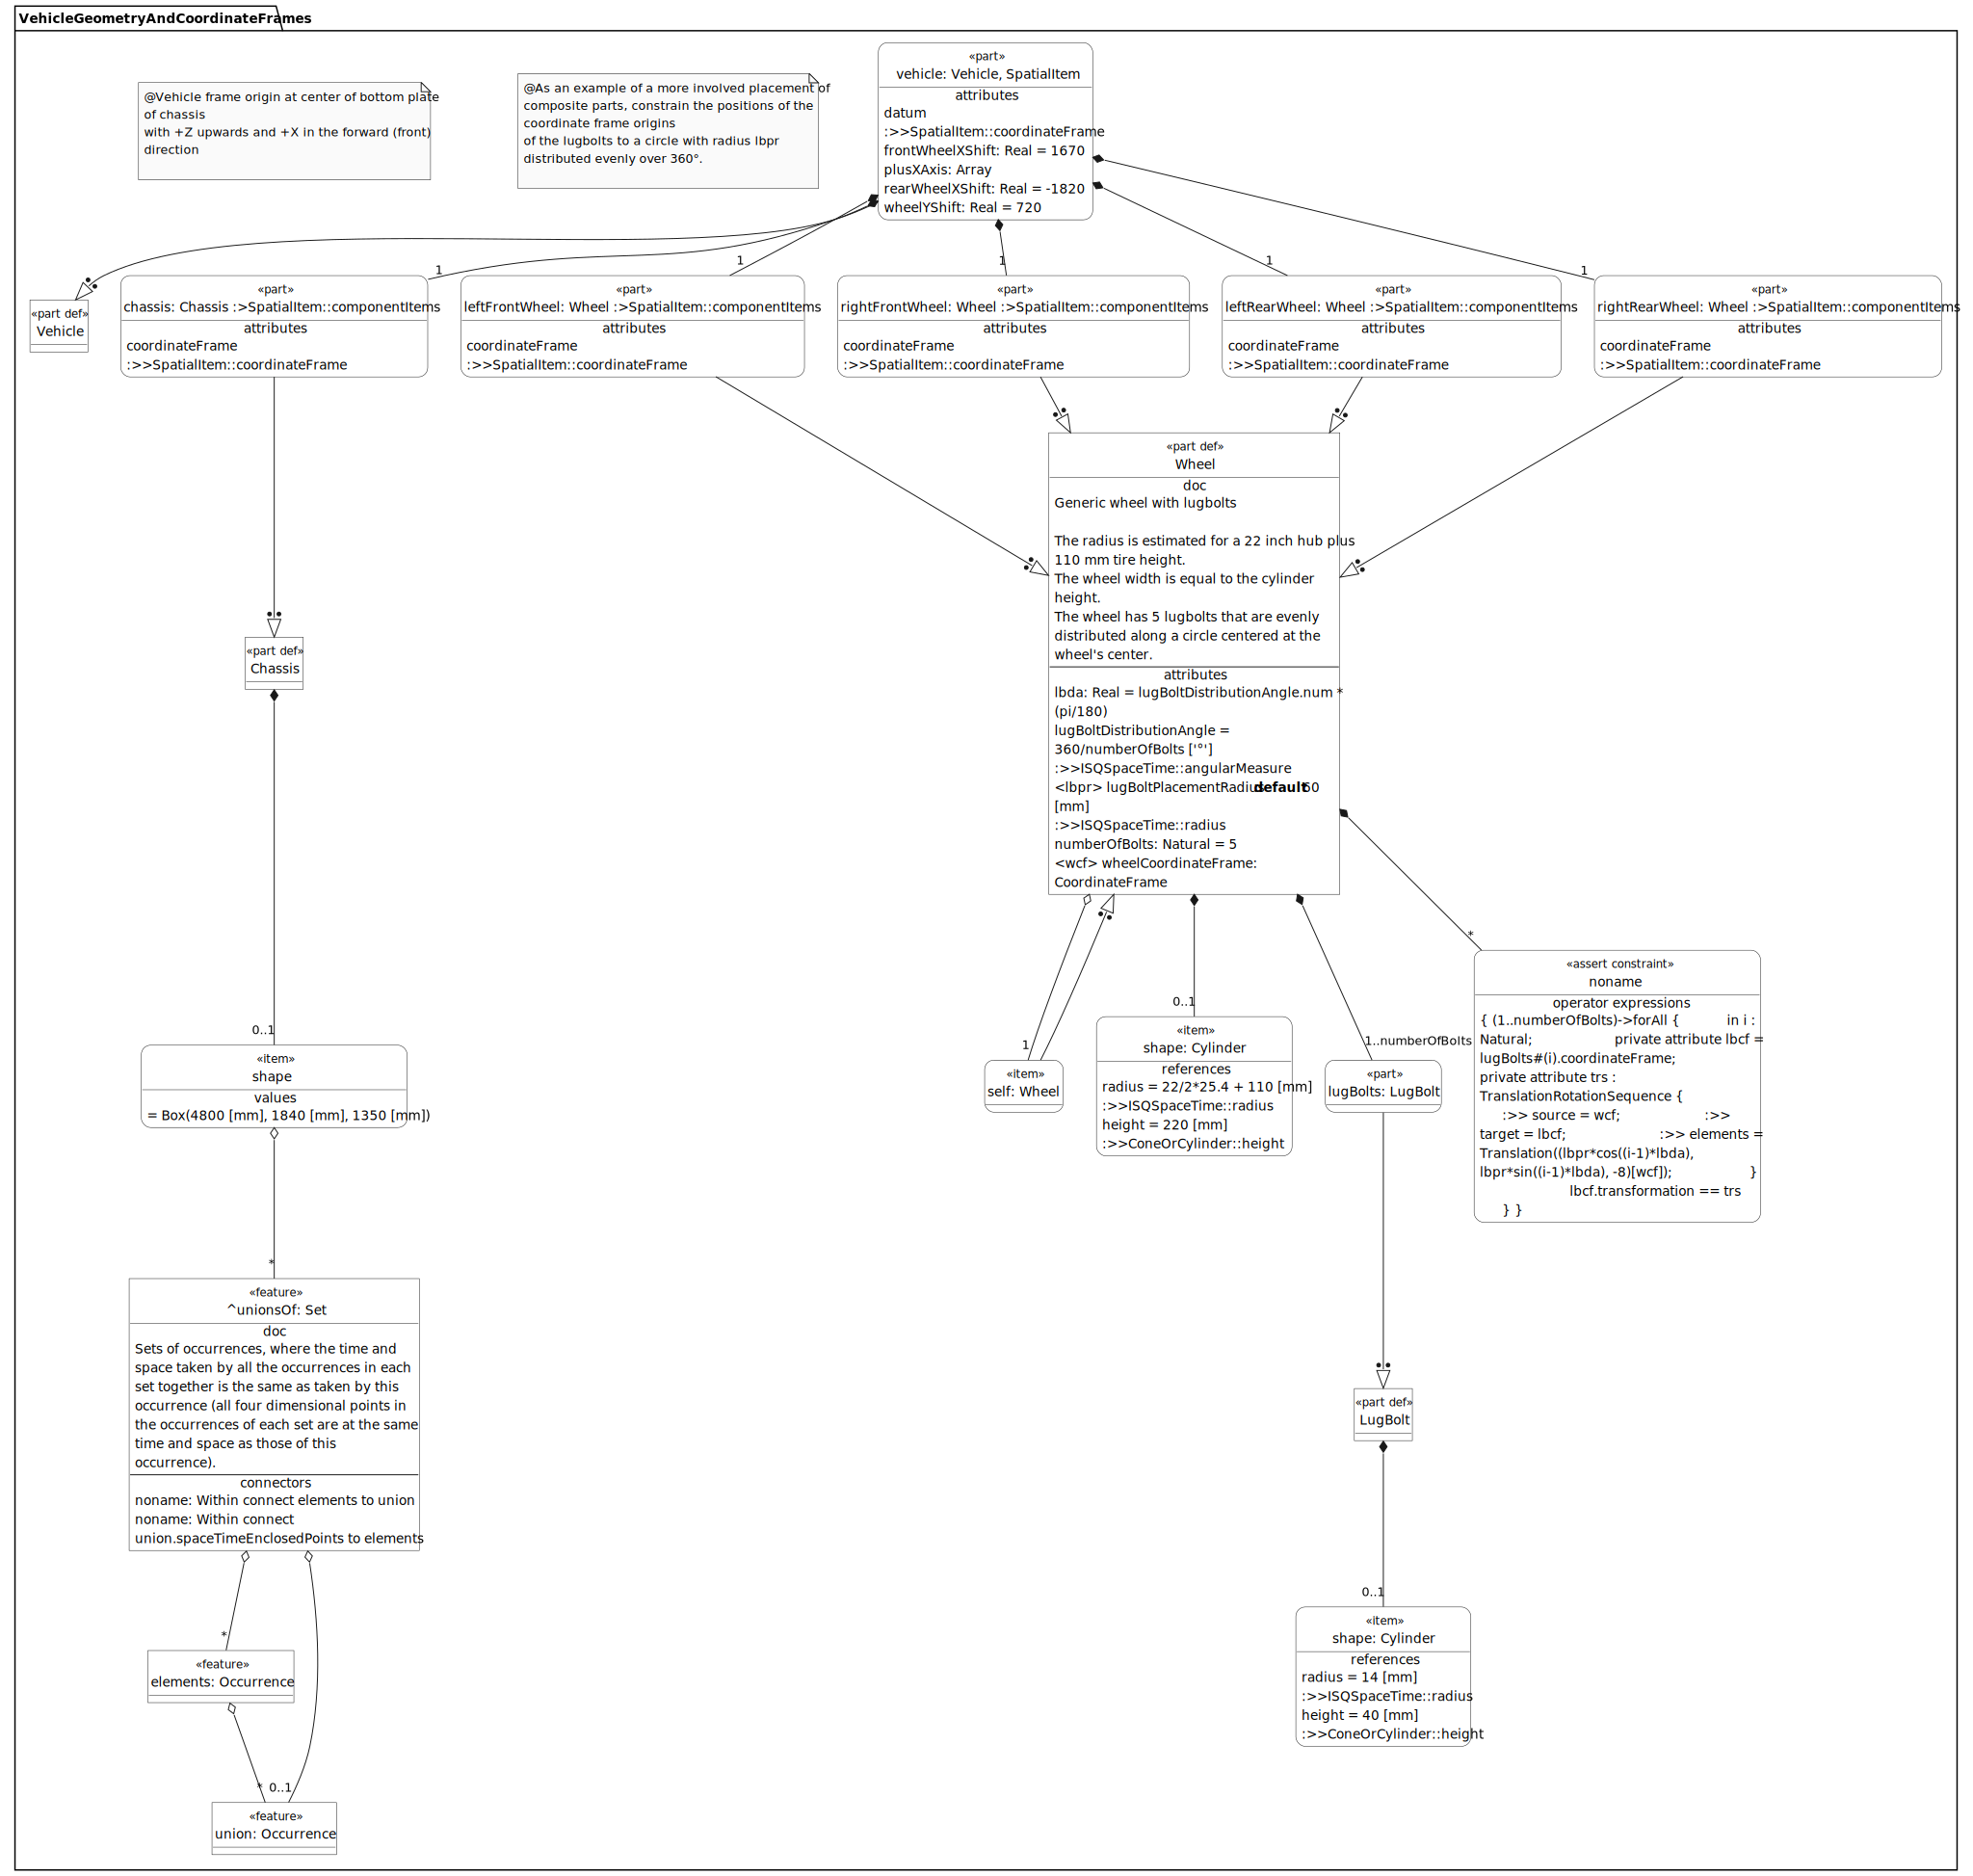

In [12]:
%viz --view=default VehicleGeometryAndCoordinateFrames

In [16]:
package ViewpointExample {	
	part def 'Systems Engineer';
	part def 'IV&V';
	
	concern 'system breakdown' {
		doc /* 
		 * To ensure that a system covers all its required capabilities,
		 * it is necessary to understand how it is broken down into
		 * subsystems and components that provide those capabilities.
		 */
		 
		stakeholder se : 'Systems Engineer';
		stakeholder ivv : 'IV&V';
	}
	
	concern 'modularity' {
		doc /*
		 * There should be well defined interfaces between the parts of
		 * a system that allow each part to be understood individually,
		 * as well as being part of the whole system.
		 */
		 
		 stakeholder se : 'Systems Engineer';
	}
	
	viewpoint 'system structure perspective' {		
		frame 'system breakdown';
		frame 'modularity';
		
		require constraint {
			doc /*
			 * A system structure view shall show the hierarchical 
			 * part decomposition of a system, starting with a 
			 * specified root part.
			 */
		}
	}
}

Package ViewpointExample (62a72447-03b7-4c28-b7d1-3533fcfe60b2)


In [13]:
%viz -h

Usage: %viz [--view=<VIEW>] [--style=<STYLE>...] <NAME> [<NAME>...]

Visualize model elements of <NAME>(s). <NAME>s must be fully qualified.

<VIEW> is case insensitive and possible candidates are:
   DEFAULT		Automatically choose an appropriate view from the given model element names
   TREE			Show a tree-structural view, like a Block Definition Diagram (BDD)
   INTERCONNECTION	Show an interconnection view, like an Internal Block Diagram (IBD)
   STATE		Show state machines
   ACTION		Show actions like an activity diagram
   SEQUENCE		Show events and messages in a sequence diagram
   MIXED		Show multiple views

<STYLE> is also case insensitive. Multiple --style options are allowed.  The possible style names are:
  DEFAULT		Standard B&&W
  STDCOLOR		Standard style with colors
  PLANTUML		PlantUML Style
  TB			Top-to-Bottom orientation
  LR			Left-to-Right orientation
  POLYLINE		Polyline style
  ORTHOLINE		Orthogonal line style
  SHOWLIB		Show elements of the standard libraries
  SHOWIN

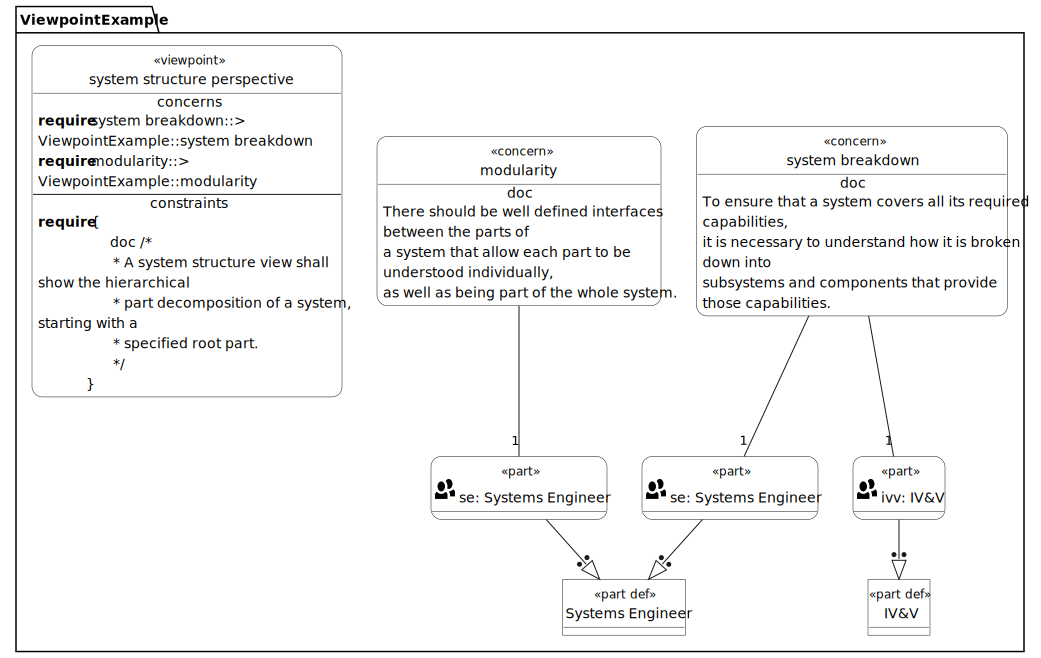

In [17]:
%viz --view=tree ViewpointExample

In [14]:
package ServerSequenceModel {
	import ScalarValues::String;
	import SignalDefinitions::*;

	package SignalDefinitions {
	    item def Subscribe {
	    	attribute topic : String;
	    	ref part subscriber;
	    }
	    
		item def Publish {
			attribute topic : String;
			ref publication;
		}
		
		item def Deliver {
			ref publication;
		}
	}

	part def PubSubSequence {
		part producer[1] {
			event occurrence publish_source_event;
		}
		
		message publish_message from producer.publish_source_event to server.publish_target_event;
		
		part server[1] {
			event occurrence subscribe_target_event;
			then event occurrence publish_target_event;
			then event occurrence deliver_source_event;
		}
		
		message subscribe_message from consumer.subscribe_source_event to server.subscribe_target_event;
		message deliver_message from server.deliver_source_event to consumer.deliver_target_event;
		
		part consumer {
			event occurrence subscribe_source_event;
			then event occurrence deliver_target_event;
		}
	}
}

Package ServerSequenceModel (ca57c58a-1c36-4a31-b44d-4a92f24399b2)


In [15]:
package ServerSequenceModelOutside {
	import ServerSequenceModel::*;

	part def PubSubSequenceOutside :> PubSubSequence {
		part :>> producer {
			event publish_source_event = publish_message.start;
		}
		
		part :>> server {
			event occurrence :>> subscribe_target_event = subscribe_message.done;
			then event occurrence :>> publish_target_event = publish_message.done;
			then event occurrence :>> deliver_source_event = deliver_message.start;
		}
		
		part :>> consumer {  /* Redundant with timing constraints on server and generic transfers. */
			event occurrence :>> subscribe_source_event = subscribe_message.start;
			then event occurrence :>> deliver_target_event = deliver_message.done;
		}
	}
}

Package ServerSequenceModelOutside (4d843c6a-be51-4e1e-ae40-df2b0aab8654)


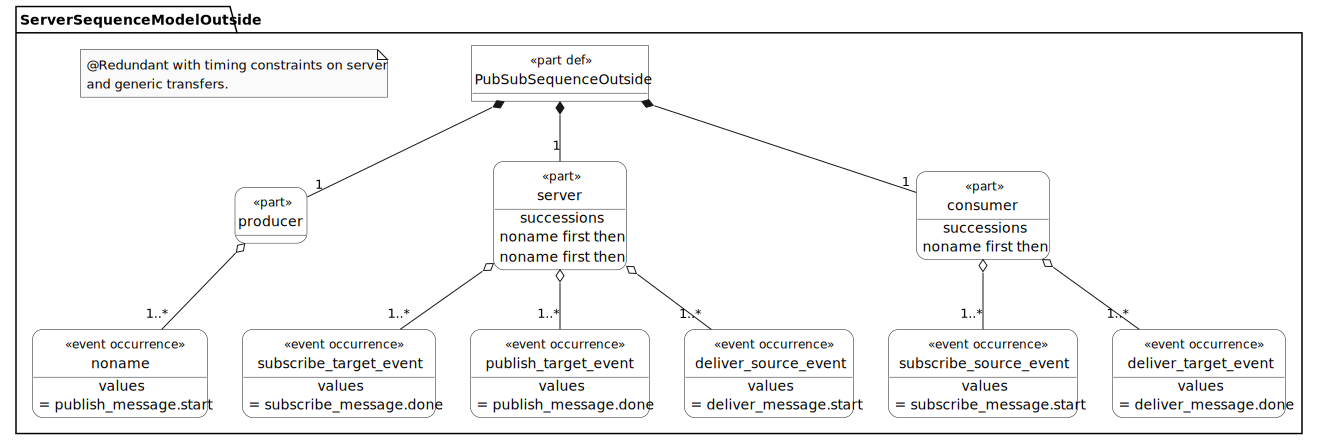

In [16]:
%viz --view=default ServerSequenceModelOutside

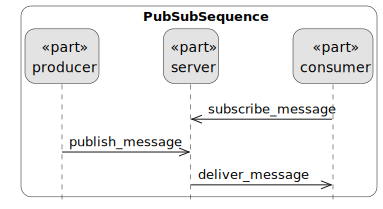

In [18]:
%viz --view=sequence ServerSequenceModel

In [3]:
%viz -h

Usage: %viz [--view=<VIEW>] [--style=<STYLE>...] <NAME> [<NAME>...]

Visualize model elements of <NAME>(s). <NAME>s must be fully qualified.

<VIEW> is case insensitive and possible candidates are:
   DEFAULT		Automatically choose an appropriate view from the given model element names
   TREE			Show a tree-structural view, like a Block Definition Diagram (BDD)
   INTERCONNECTION	Show an interconnection view, like an Internal Block Diagram (IBD)
   STATE		Show state machines
   ACTION		Show actions like an activity diagram
   SEQUENCE		Show events and messages in a sequence diagram
   MIXED		Show multiple views

<STYLE> is also case insensitive. Multiple --style options are allowed.  The possible style names are:
  DEFAULT		Standard B&&W
  STDCOLOR		Standard style with colors
  PLANTUML		PlantUML Style
  TB			Top-to-Bottom orientation
  LR			Left-to-Right orientation
  POLYLINE		Polyline style
  ORTHOLINE		Orthogonal line style
  SHOWLIB		Show elements of the standard libraries
  SHOWIN